In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%load_ext jupyternotify

import numpy as np

import torch
import torch.nn
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

from meld.recon import UnrolledNetwork
from meld.util import getAbs, getPhase
from meld.model import pytorch_proximal


import h5py
import mri
import model
import dataloader
import lib_complex as cp
import time as time 
import os

<IPython.core.display.Javascript object>

In [2]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
# Setup device
device_no = 0
torch.cuda.set_device(device_no)
device = torch.device("cuda:"+str(device_no) if torch.cuda.is_available() else "cpu")

np_dtype = np.float32
device

device(type='cuda', index=0)

In [3]:
# edit this to datapath for 2D brain data
datapath = '/mikQNAP/dataset_train_full.h5'
dataset = dataloader.dataloader(datapath, 
                                noise_std = 3e-2)
full_len = len(dataset)
train_len = int(0.8*full_len)
test_len = full_len - train_len
train_set, test_set = torch.utils.data.random_split(dataset, [train_len, test_len])
batch_size = 4

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=4)

# tried: noise_std=1e-1 (kinda hard), 5e-2, 1e-2 (too easy)
imgs, maps, meas, mask = dataset[150]

imgs_test = imgs.unsqueeze(0).to(device)
maps_test = maps.unsqueeze(0).to(device)
meas_test = meas.unsqueeze(0).to(device)
mask_test = mask.unsqueeze(0).to(device)

print(imgs_test.shape, maps_test.shape, meas_test.shape, mask_test.shape)
print(len(train_set))

torch.Size([1, 256, 232, 2]) torch.Size([1, 12, 256, 232, 2]) torch.Size([1, 12, 256, 232, 2]) torch.Size([1, 256, 232])
288


## Checking MRI utility functions

In [4]:
out = mri.maps_forw(imgs_test, maps_test)
out_fft = mri.fft_forw(out)
out_masked_fft = mri.mask_forw(out_fft, mask_test)
out_masked = mri.fft_adj(out_masked_fft)
out_compressed = mri.maps_adj(out_masked, maps_test)
out_adj = mri.sense_adj(meas_test, maps_test, mask_test)

compressed = mri.maps_adj(out, maps_test)
out1 = mri.sense_forw(imgs_test, maps_test, mask_test)
print(out.shape)

# check gradient with backprop

torch.Size([1, 12, 256, 232, 2])


<IPython.core.display.Javascript object>


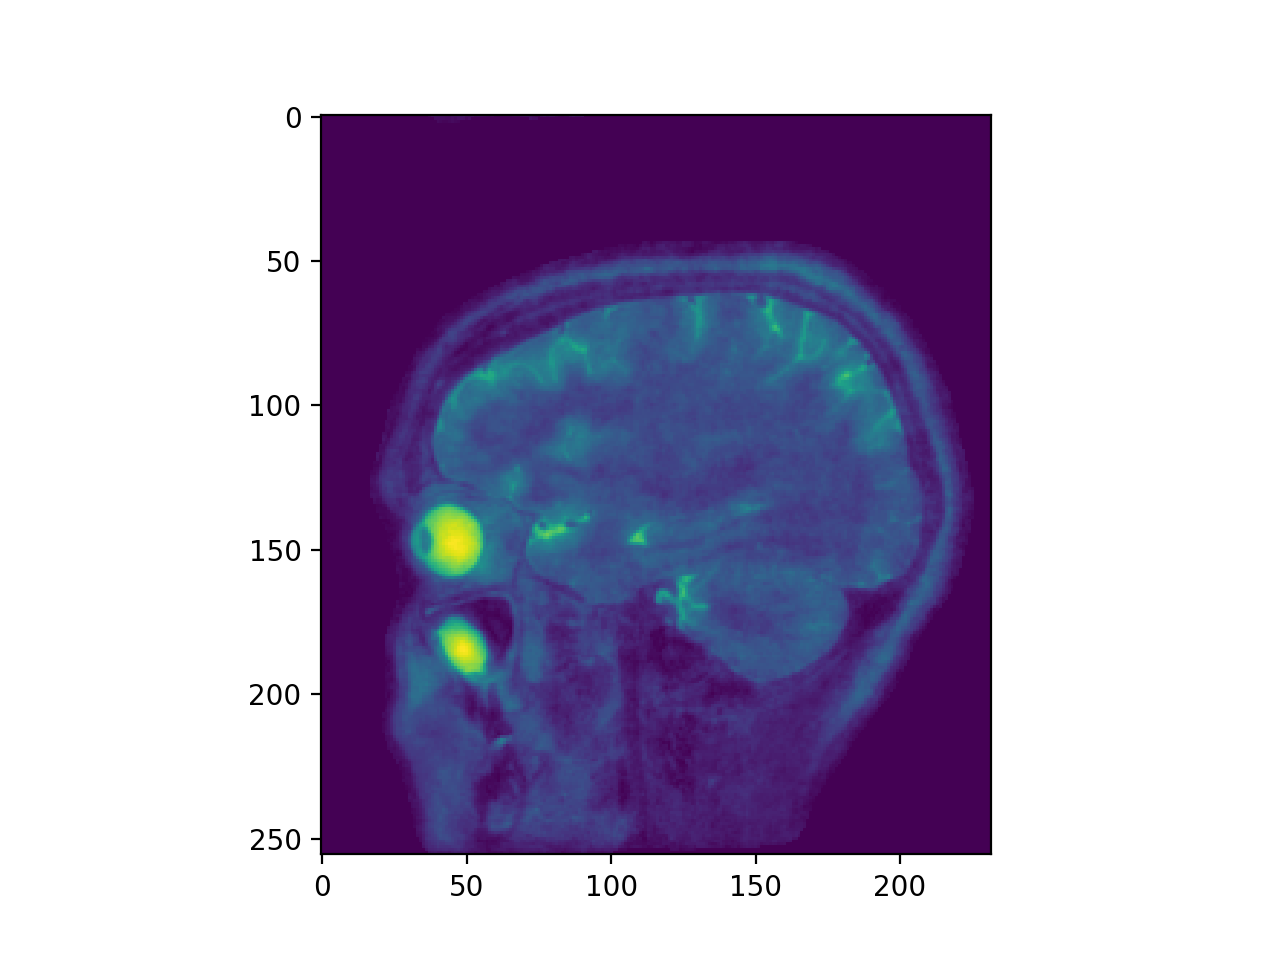

In [5]:
plt.figure()
# plt.imshow(getAbs(out_fft[0,0,...]).cpu().numpy())
# plt.imshow(getAbs(compressed[0,...]).cpu().numpy())
# plt.imshow(getAbs(imgs_test[0,...]).cpu().numpy())
# plt.imshow(getAbs(out_masked[0,5,...]).cpu().numpy())
plt.imshow(getAbs(out_adj[0,...]).cpu().numpy())
plt.show()

<IPython.core.display.Javascript object>


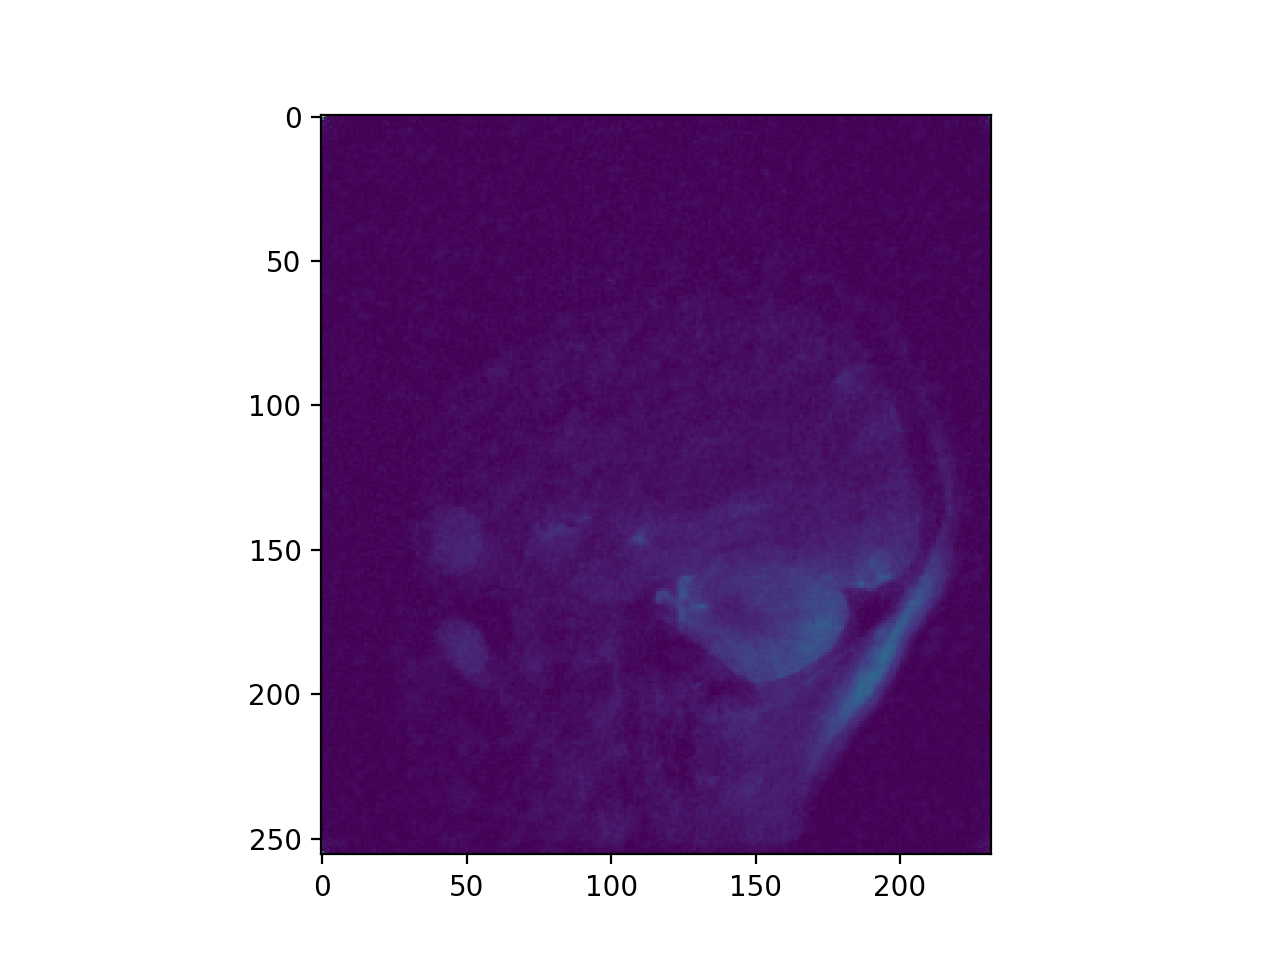

In [6]:
plt.figure()
plt.imshow(getAbs(mri.fft_adj(meas_test[0,5,...])).cpu().numpy())
plt.show()

In [8]:
mri_model = mri.MultiChannelMRI(device = device)
adjoint1 = mri_model.batch(imgs_test, maps_test, meas_test, mask_test, device)
adjoint = mri.sense_adj(meas_test, maps_test, mask_test).to(device)
zeros_test = torch.zeros_like(adjoint).to(device)
with torch.no_grad():
    recon = mri_model(zeros_test, device = device, max_iter=100)

## Forward Reverse test
prints the normalized rmse between input and reverse for different number of unrolled conjugate gradient iterations

In [9]:
with torch.no_grad():
    reverse = mri_model.reverse(recon, device = device)

<IPython.core.display.Javascript object>


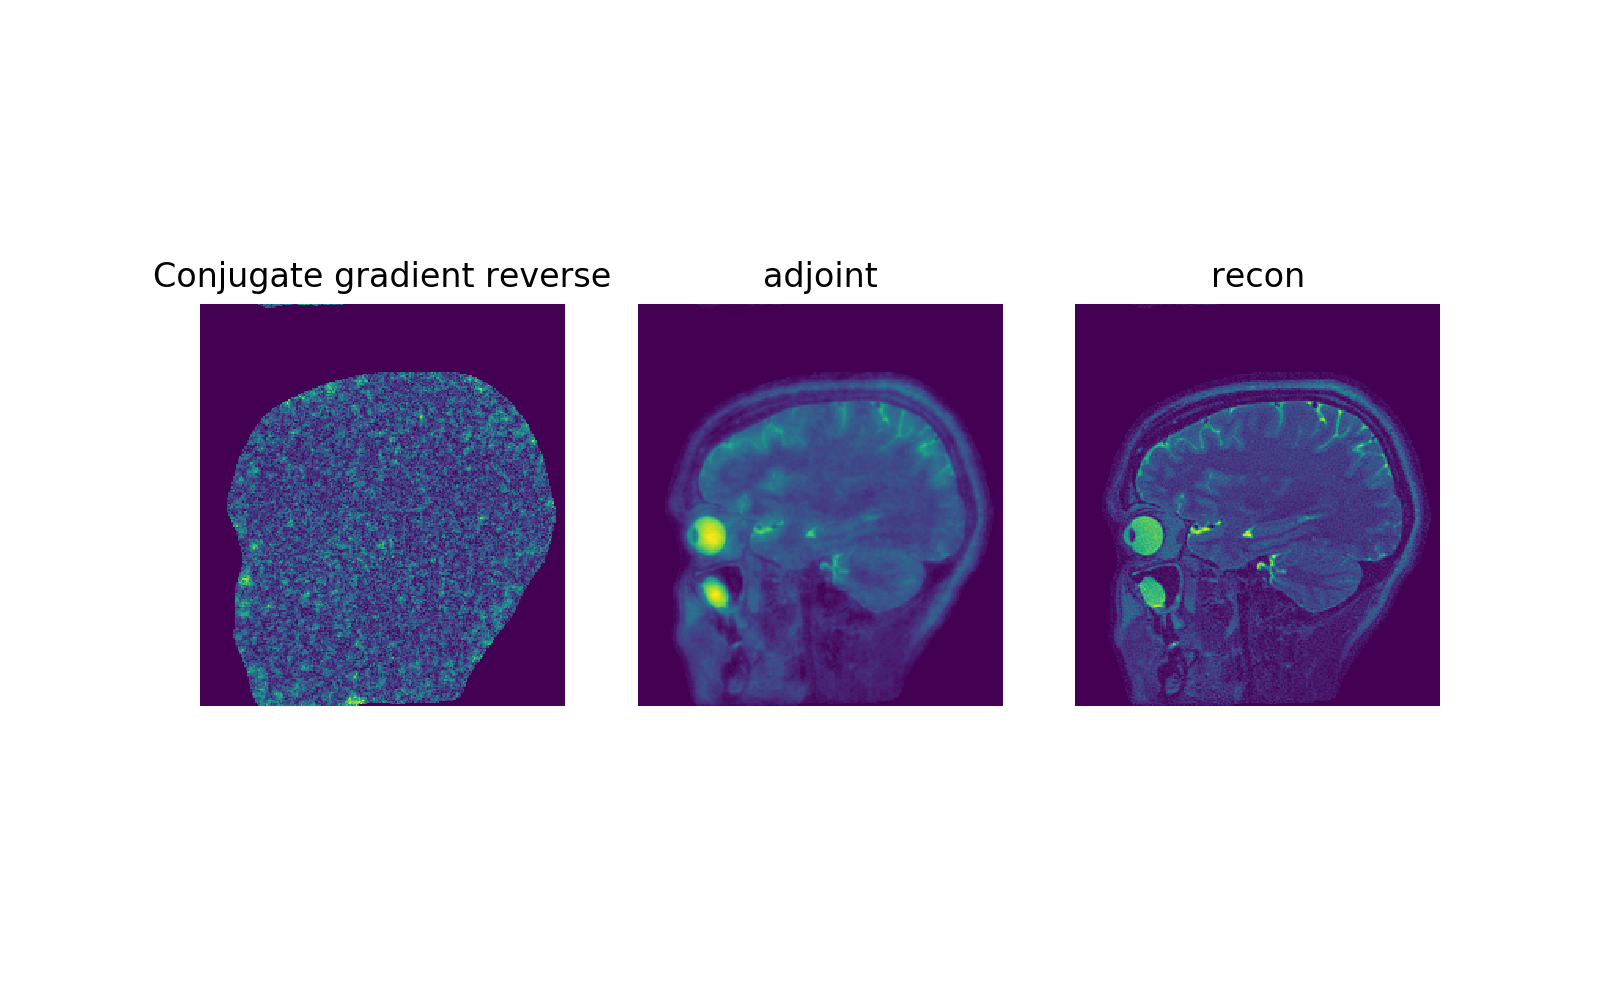

Text(0.5, 1.0, 'recon')

In [10]:
plt.figure(figsize=(8,5))
plt.subplot(131)
plt.imshow(getAbs(reverse[0,...]).cpu().numpy())
plt.axis('off')
plt.title('Conjugate gradient reverse')
plt.subplot(132)
plt.imshow(getAbs(adjoint1[0,...]).cpu().numpy())
plt.axis('off')
plt.title('adjoint')
plt.subplot(133)
plt.imshow(getAbs(recon[0,...]).cpu().numpy())
plt.axis('off')
plt.title('recon')

In [11]:
print(torch.sum((getAbs(reverse[0,...]) - getAbs(zeros_test[0,...]))**2) / (256 * 232))
print(torch.sum((getAbs(imgs_test[0,...]) - getAbs(recon[0,...]))**2) / (256 * 232))

tensor(1.5033e-05, device='cuda:0')
tensor(0.0006, device='cuda:0')
